In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.under_sampling import RandomUnderSampler

In [1]:
import pandas as pd

try:
    df = pd.read_csv('https://github.com/enricochandran/Dataset-ML/raw/refs/heads/main/RegresiUTSTelkom.csv')
    display(df.head())
    print(df.shape)
except FileNotFoundError:
    print("Error")
    df = None

,2001,49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
0,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
1,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
2,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
3,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
4,2001,50.54767,0.31568,92.35066,22.38696,-25.51870,-19.04928,20.67345,-5.19943,3.63566,...,6.59753,-50.69577,26.02574,18.94430,-0.33730,6.09352,35.18381,5.00283,-11.02257,0.02263


(515344, 91)


In [2]:
print(df.isnull().sum())

df.drop_duplicates(inplace=True)
print(f"Shape after removing duplicates: {df.shape}")

numerical_cols = df.select_dtypes(include=['number']).columns
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
print(f"Shape after outlier handling: {df.shape}")

print(df.dtypes)

display(df.head())

2001         0
49.94357     0
21.47114     0
73.0775      0
8.74861      0
            ..
-23.08793    0
68.40795     0
-1.82223     0
-27.46348    0
2.26327      0
Length: 91, dtype: int64
Shape after removing duplicates: (515130, 91)
Shape after outlier handling: (37269, 91)
2001           int64
49.94357     float64
21.47114     float64
73.0775      float64
8.74861      float64
              ...   
-23.08793    float64
68.40795     float64
-1.82223     float64
-27.46348    float64
2.26327      float64
Length: 91, dtype: object


,2001,49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
18,1987,39.71092,-4.92800,12.88590,-11.87773,2.48031,-16.11028,-16.40421,-8.29657,9.86817,...,11.92816,-73.72412,16.19039,9.79606,9.71693,-9.90907,-20.65851,2.34002,-31.57015,1.58400
25,1996,45.84368,38.11148,-8.63596,-13.28665,-38.21077,-14.98402,-0.18219,-5.22133,1.20037,...,10.73204,-78.91793,37.25806,8.81152,13.84919,41.64984,-65.59314,9.52777,16.43339,4.45222
29,1997,45.52338,2.79013,8.00527,-9.91837,7.54397,-17.30311,5.51034,-3.38012,4.93012,...,0.99479,32.22234,10.63270,-6.13042,9.98918,9.61685,-78.58798,4.58669,2.60033,-9.13155
35,2000,50.86288,56.57130,12.01148,-9.15581,-20.46014,-16.30729,-8.77505,-7.43052,6.67630,...,-10.89199,-45.76734,5.42290,14.99974,2.21268,57.81646,4.36321,7.12878,54.21828,-3.97173
42,2000,50.76908,29.84010,16.48637,-8.54749,-24.62551,-15.91986,-1.68566,-6.65610,7.63505,...,7.02065,-10.35473,19.77636,21.40832,2.45389,-8.97767,13.42308,1.56669,39.49377,0.55789


,2001,49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
count,37269.000000,37269.000000,37269.000000,37269.000000,37269.000000,37269.000000,37269.000000,37269.000000,37269.000000,37269.000000,...,37269.000000,37269.000000,37269.000000,37269.000000,37269.000000,37269.000000,37269.000000,37269.000000,37269.000000,37269.000000
mean,2000.037887,49.387713,33.568444,22.813040,-4.794115,-18.610851,-19.561134,-0.861157,-1.213751,6.341311,...,1.504162,-30.899296,10.031729,25.777849,0.587815,3.377525,-14.567917,1.736699,-5.719008,-0.417197
std,7.870420,3.235156,29.981019,19.158707,7.615333,17.675453,6.824987,10.518110,4.946763,7.938712,...,7.726126,47.424478,37.210277,27.183119,4.827960,33.616431,53.044261,3.962099,47.826602,5.607403
min,1976.000000,29.350600,-112.892510,-66.852870,-32.722880,-62.975740,-41.427070,-33.795440,-19.674010,-18.560650,...,-19.871230,-163.695010,-94.447390,-51.078230,-12.777530,-89.323690,-163.723520,-9.139230,-136.760090,-15.459140
25%,1995.000000,47.637980,15.262800,10.715460,-9.750040,-30.893630,-24.459740,-7.703820,-4.461890,0.921700,...,-3.472150,-60.727230,-14.595120,7.485590,-2.593300,-18.987740,-48.205640,-0.866310,-37.293150,-3.984790
50%,2002.000000,50.089780,35.406230,22.815410,-4.824840,-18.869140,-20.173950,-0.920440,-1.107160,6.255750,...,1.076920,-28.765580,9.982040,24.808030,0.412210,2.612800,-12.201330,1.697550,-6.802090,-0.314650
75%,2006.000000,51.731040,53.710360,35.117150,0.077400,-6.516160,-15.394880,6.002760,2.155570,11.781310,...,6.088250,-0.021270,34.450580,43.459960,3.665780,25.346370,20.537770,4.333070,25.212000,3.139360
max,2010.000000,59.499770,127.405870,88.383530,30.914510,46.755950,15.522110,30.444170,15.484510,26.960950,...,24.028780,100.445790,113.795440,102.726840,14.143860,97.365240,132.278800,12.668860,125.334530,14.555600


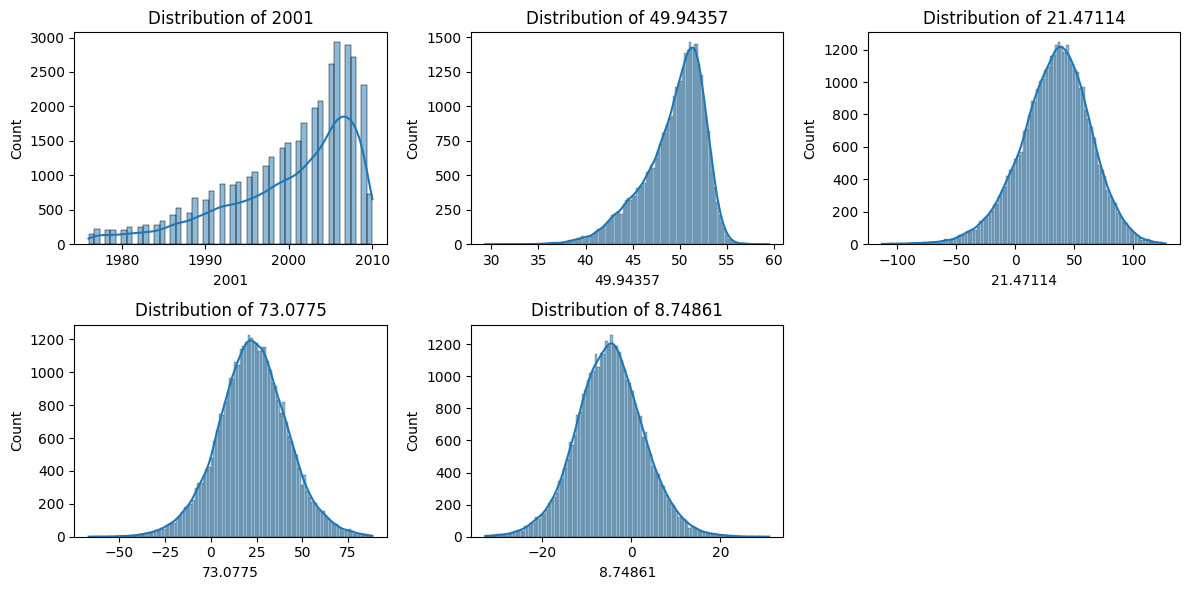

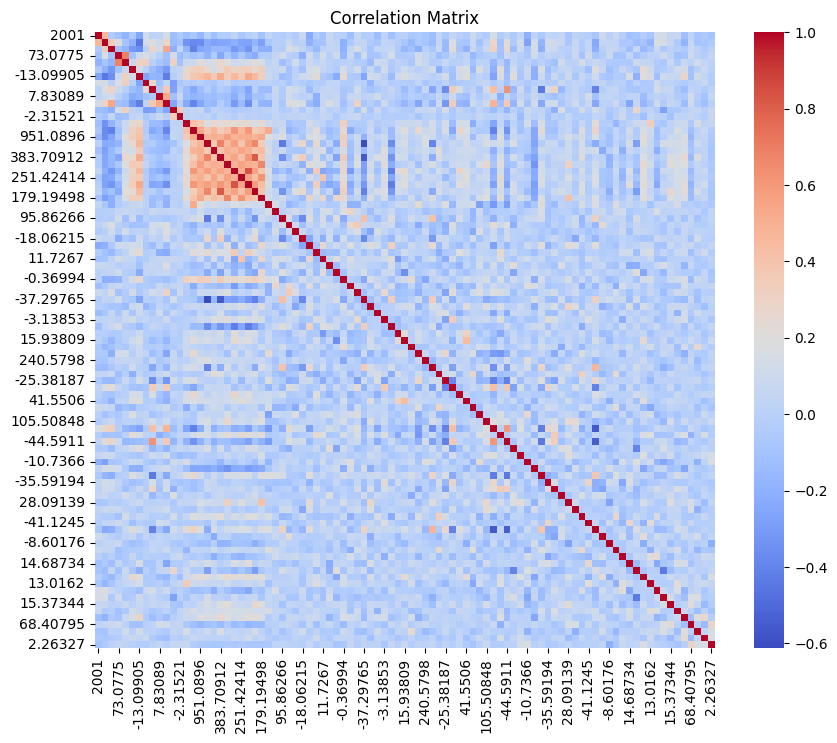

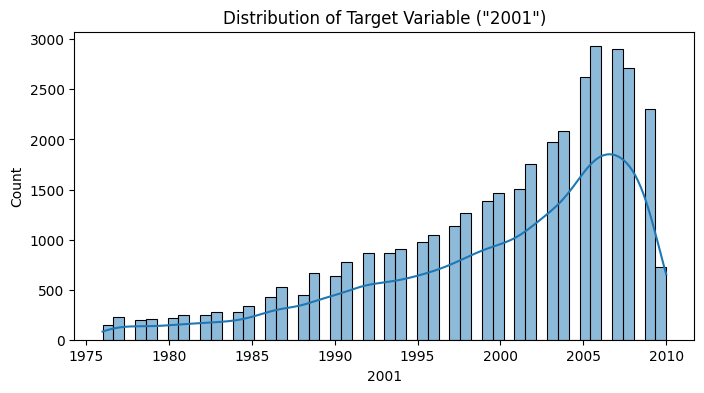

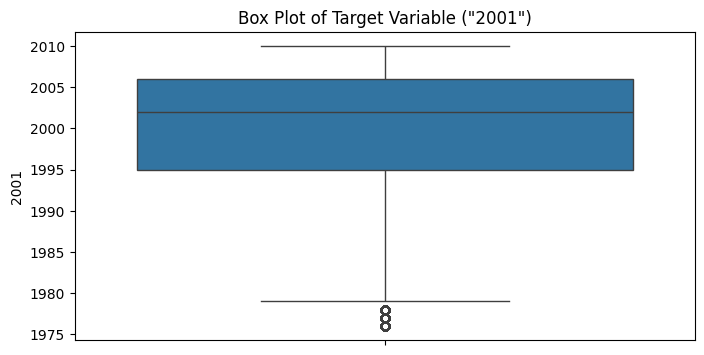

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = df.select_dtypes(include=['number']).columns
display(df[numerical_features].describe())

plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_features[:5]):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df['2001'], kde=True)
plt.title('Distribution of Target Variable ("2001")')
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(y=df['2001'])
plt.title('Box Plot of Target Variable ("2001")')
plt.show()


In [5]:
!pip install imblearn
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split

nm = NearMiss()
X = df.drop('2001', axis=1)
y = df['2001']
X_resampled, y_resampled = nm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.2 MB/s eta 0:00:00


In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

numerical_features = X_train.select_dtypes(include=['number']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_features])
X_test_scaled = scaler.transform(X_test[numerical_features])

if len(categorical_features) > 0:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_encoded = encoder.fit_transform(X_train[categorical_features])
    X_test_encoded = encoder.transform(X_test[categorical_features])

    X_train_final = np.concatenate((X_train_scaled, X_train_encoded), axis=1)
    X_test_final = np.concatenate((X_test_scaled, X_test_encoded), axis=1)
else:
    X_train_final = X_train_scaled
    X_test_final = X_test_scaled

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression
from sklearn.feature_selection import chi2, f_classif
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

vt = VarianceThreshold(threshold=0.01)
X_train_var = vt.fit_transform(X_train_final)
X_test_var = vt.transform(X_test_final)

selected_indices = vt.get_support(indices=True)
selected_features = X_train.columns[selected_indices]

X_train_final = pd.DataFrame(X_train_var, columns=selected_features)
X_test_final = pd.DataFrame(X_test_var, columns=selected_features)

corr_matrix = X_train_final.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
X_train_final.drop(to_drop, axis=1, inplace=True)
X_test_final.drop(to_drop, axis=1, inplace=True)

mi_scores = mutual_info_regression(X_train_final, y_train)
k = 20
mi_indices = np.argsort(mi_scores)[::-1][:k]
selected_features_mi = X_train_final.columns[mi_indices]

X_train_final = X_train_final[selected_features_mi]
X_test_final = X_test_final[selected_features_mi]

X_train_final = np.array(X_train_final)
X_test_final = np.array(X_test_final)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

lr_model = LinearRegression()
pr_model = LinearRegression()
dtr_model = DecisionTreeRegressor(random_state=42)
knr_model = KNeighborsRegressor()
br_model = BaggingRegressor(random_state=42)
abr_model = AdaBoostRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)
svr_model = SVR()

lr_model.fit(X_train_final, y_train)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_final)
X_test_poly = poly.transform(X_test_final)
pr_model.fit(X_train_poly, y_train)


dtr_model.fit(X_train_final, y_train)
knr_model.fit(X_train_final, y_train)
br_model.fit(X_train_final, y_train)
abr_model.fit(X_train_final, y_train)
gbr_model.fit(X_train_final, y_train)
svr_model.fit(X_train_final, y_train)

models = {
    'LinearRegression': lr_model,
    'PolynomialFeatures': pr_model,
    'DecisionTreeRegressor': dtr_model,
    'KNeighborsRegressor': knr_model,
    'BaggingRegressor': br_model,
    'AdaBoostRegressor': abr_model,
    'GradientBoostingRegressor': gbr_model,
    'SVR': svr_model
}

Model: LinearRegression
RMSE: 7.8504785905669205
MSE: 61.63001410094958
R-squared: 0.4245063914606062


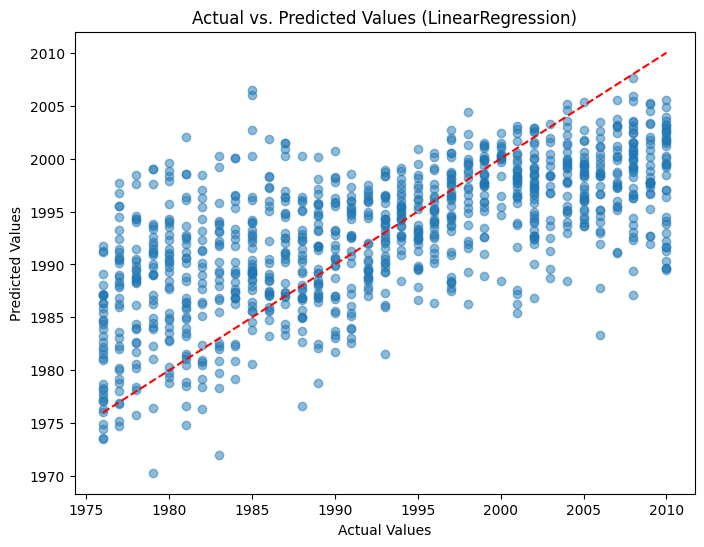

Model: PolynomialFeatures
RMSE: 7.366533706867177
MSE: 54.26581885441026
R-squared: 0.49327235489974597


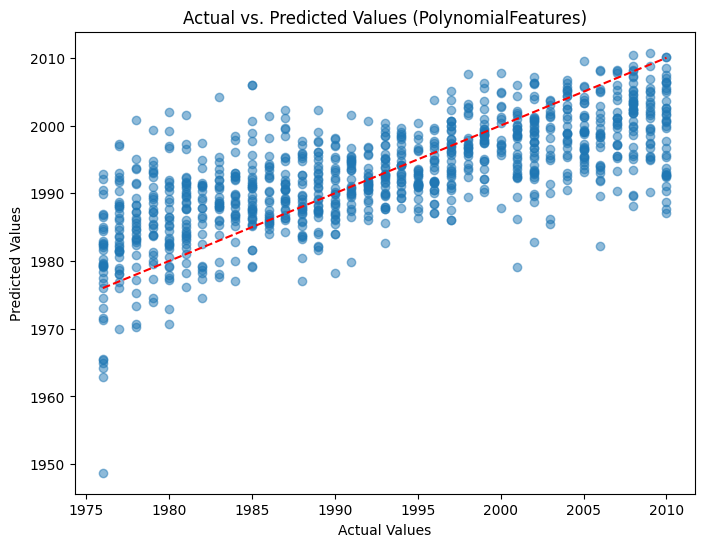

Model: DecisionTreeRegressor
RMSE: 10.252821672617213
MSE: 105.12035225048923
R-squared: 0.01839888031708037


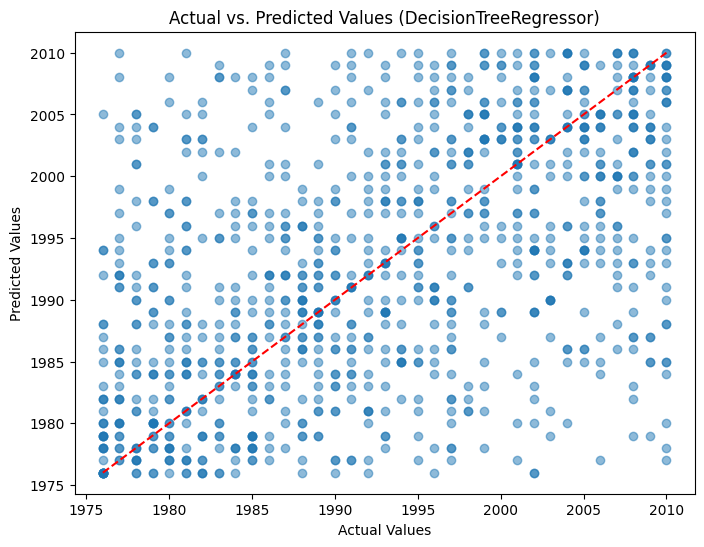

Model: KNeighborsRegressor
RMSE: 8.373343221935231
MSE: 70.11287671232868
R-squared: 0.34529444763450146


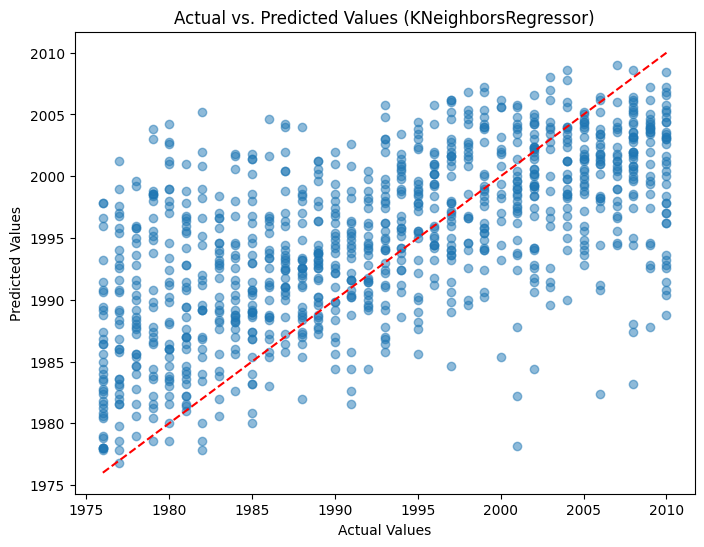

Model: BaggingRegressor
RMSE: 7.660533083492799
MSE: 58.683767123287694
R-squared: 0.45201808895990625


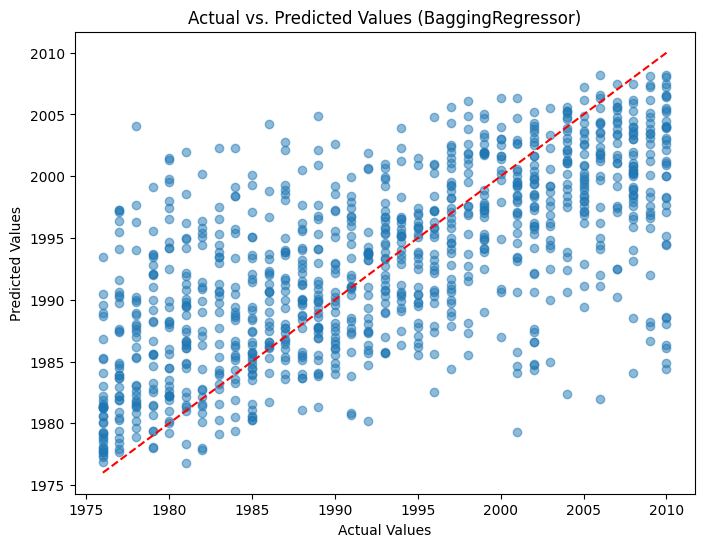

Model: AdaBoostRegressor
RMSE: 8.346498113216212
MSE: 69.66403075392179
R-squared: 0.3494857168407488


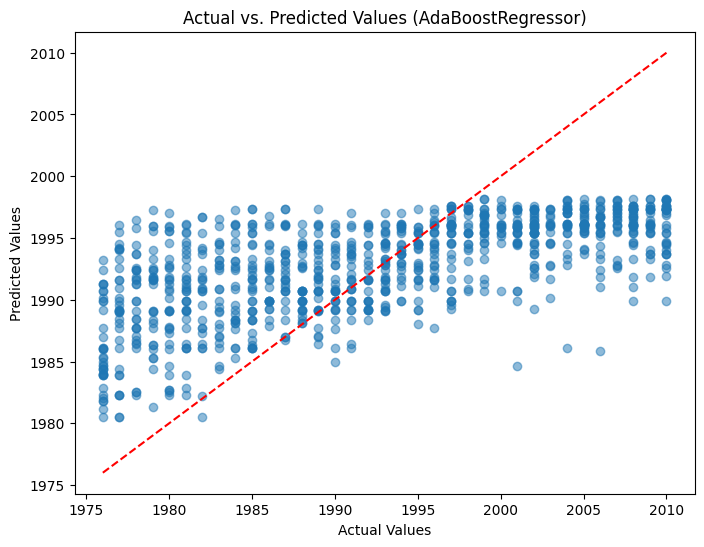

Model: GradientBoostingRegressor
RMSE: 7.250973857800205
MSE: 52.57662188650199
R-squared: 0.5090458716314313


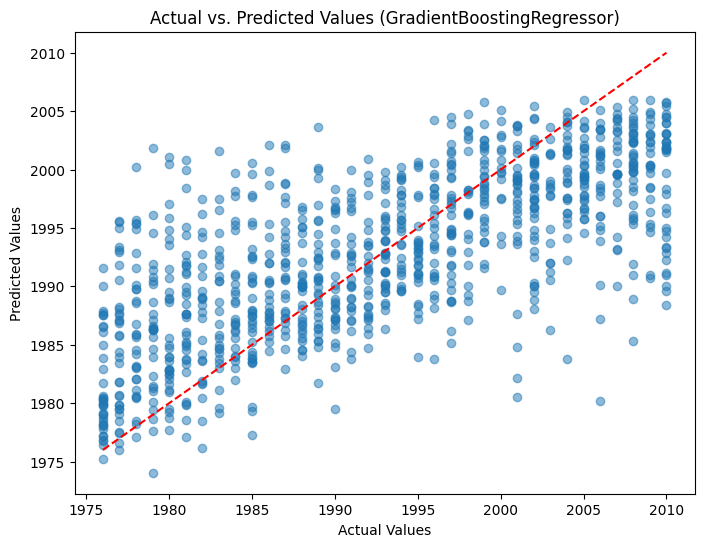

Model: SVR
RMSE: 7.173474764155653
MSE: 51.45874019197801
R-squared: 0.5194845155241288


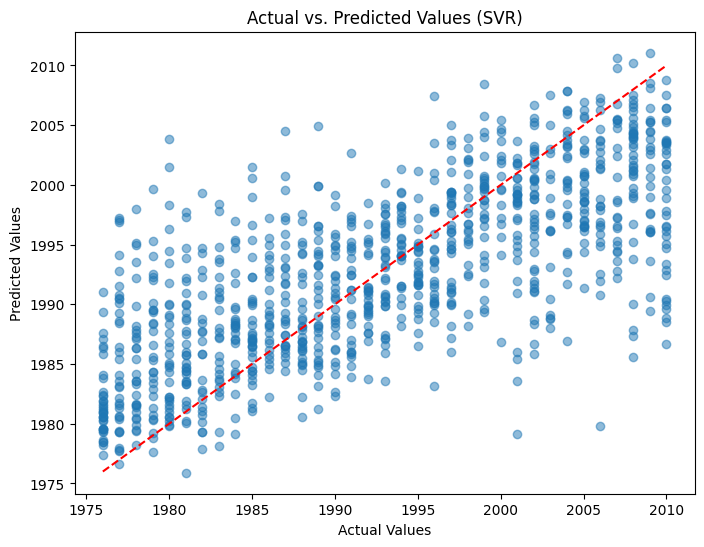

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt

for model_name, model in models.items():
    if model_name == 'PolynomialFeatures':
        y_pred = model.predict(X_test_poly)
    else:
        y_pred = model.predict(X_test_final)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"RMSE: {rmse}")
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs. Predicted Values ({model_name})")
    plt.show()

    if r2 < 0:
        print(f"Warning: Negative R-squared value for {model_name}. Consider alternative approaches.")

In [10]:
import pandas as pd

model_performance = {}

for model_name, model in models.items():
    if model_name == 'PolynomialFeatures':
        y_pred = model.predict(X_test_poly)
    else:
        y_pred = model.predict(X_test_final)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    model_performance[model_name] = {'RMSE': rmse, 'MSE': mse, 'R-squared': r2}

performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
display(performance_df)

best_model = performance_df['RMSE'].idxmin()
print(f"\nThe best performing model is: {best_model}")
print("Justification: Based on RMSE, lower values indicate better performance. The model with the lowest RMSE is considered the best.\n")

print(f"Summary:")
print(f"Best Model: {best_model}")
print(f"RMSE: {performance_df.loc[best_model, 'RMSE']}")
print(f"MSE: {performance_df.loc[best_model, 'MSE']}")
print(f"R-squared: {performance_df.loc[best_model, 'R-squared']}")

,RMSE,MSE,R-squared
LinearRegression,7.850479,61.630014,0.424506
PolynomialFeatures,7.366534,54.265819,0.493272
DecisionTreeRegressor,10.252822,105.120352,0.018399
KNeighborsRegressor,8.373343,70.112877,0.345294
BaggingRegressor,7.660533,58.683767,0.452018
AdaBoostRegressor,8.346498,69.664031,0.349486
GradientBoostingRegressor,7.250974,52.576622,0.509046
SVR,7.173475,51.458740,0.519485



The best performing model is: SVR
Justification: Based on RMSE, lower values indicate better performance. The model with the lowest RMSE is considered the best.

Summary:
Best Model: SVR
RMSE: 7.173474764155653
MSE: 51.45874019197801
R-squared: 0.5194845155241288


# Model mana yang memberikan performa terbaik, dan mengapa?

Support Vector Regressor (SVR) menunjukkan performa terbaik berdasarkan nilai Root Mean Squared Error (RMSE) terendah yaitu 7.173. Analisis terutama berfokus pada nilai RMSE, dengan asumsi bahwa semakin rendah RMSE maka semakin baik performa model. Metrik lainnya seperti MSE dan R-squared juga dipertimbangkan, namun tidak menggantikan RMSE sebagai kriteria utama pemilihan model.

# Metrik evaluasi mana yang dianggap paling tepat untuk tugas ini?

RMSE digunakan sebagai metrik utama untuk pemilihan model, dengan memprioritaskan model yang mampu meminimalkan prediction error.

# Pembersihan Data:

Sejumlah besar data duplikat dihapus (dari 515.130 menjadi 37.269 baris), serta dilakukan penghapusan outlier yang berdampak pada ukuran dataset. Tidak ditemukan missing value dalam data.

# Seleksi Fitur:

Fitur dengan nilai konstan, kuasi-konstan, serta fitur yang memiliki korelasi tinggi (koefisien korelasi > 0.95) dihapus. Mutual Information digunakan untuk memilih 20 fitur teratas berdasarkan relevansinya terhadap target variable.

# Performa Model:

Model SVR mencapai RMSE terendah (7.173), MSE sebesar 51.46, serta nilai R-squared yang relatif tinggi (0.52) dibandingkan model lainnya. Model lain menunjukkan performa yang bervariasi, dengan Gradient Boosting Regressor sebagai model dengan performa terbaik kedua berdasarkan RMSE.

# Feature Engineering:

Fitur numerik diskalakan menggunakan StandardScaler dan tidak terdapat fitur kategorikal yang memerlukan encoding.

# Hyperparameter Tuning:

Lakukan eksplorasi hyperparameter tuning pada model dengan performa terbaik (SVR dan Gradient Boosting Regressor) untuk meningkatkan performa lebih lanjut. Fokus pada parameter yang berpotensi memberikan dampak besar terhadap ruang fitur.

# Alternatif Metode Seleksi Fitur:

Pertimbangkan penggunaan teknik seleksi fitur lain (misalnya recursive feature elimination, feature importance dari model berbasis pohon) untuk melihat apakah dapat meningkatkan performa model. Pertimbangkan juga metode yang dapat menangkap interaksi antar fitur.